# Импортируем библиотеки

In [1]:
from lightgbm import LGBMRegressor
import pandas as pd
import lightgbm as lgb
from sklearn.inspection import permutation_importance
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import os
import contextlib
import warnings
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.model_selection import  GridSearchCV
from tqdm import tqdm
import statsmodels.api as sm

# Загрузка данных

Будем использовать le кодировку, так как будем работать с lightgbm

In [2]:
df_le=pd.read_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_feat_eng_le.csv")
df_mte=pd.read_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_feat_eng_mte.csv")
df_le=df_le.drop('Unnamed: 0', axis=1)
df_mte=df_mte.drop('Unnamed: 0', axis=1)
df_le.sample(5)

,metro_name,time_to_metro,num_rooms,total_area,year_house,kitchen_area,repair,price,floors,num_floor,...,district,metro_line,metro_distance,distr*time,Kre*time,Kre*area,year*area,year*repair,year*floors,area/num+1
20754,Саларьево,5.0,3,44.5,1700.0,9.0,0,14148762.0,14.0,0.214286,...,42,13,6.65,210.0,98.250,874.425,75650.0,0.0,23800.0,11.125
14779,Новопеределкино,2.5,3,36.0,1700.0,6.0,1,22990000.0,23.0,0.217391,...,57,11,10.35,142.5,50.875,732.600,61200.0,1700.0,39100.0,9.000
22165,Царицыно,15.0,2,34.5,1700.0,8.0,0,18000000.0,11.0,0.272727,...,25,10,7.34,375.0,245.100,563.730,58650.0,0.0,18700.0,11.500
18235,Дмитровская,5.0,3,41.5,1700.0,5.0,0,32975890.0,36.0,0.583333,...,104,6,-0.25,520.0,33.750,280.125,70550.0,0.0,61200.0,10.375
4163,Алексеевская,13.0,3,52.0,2023.0,13.0,2,36359736.0,34.0,0.970588,...,100,7,1.56,1300.0,85.280,341.120,105196.0,4046.0,68782.0,13.000


In [3]:
df_le.shape

(27974, 26)

# Важности признаков

Будем двигаться от более легких методов к более сложным.

## Split 

Посмотрим простейший способ получения важности под названием split, который встроен в lightgbm. Важность признака определяется по количеству использований признака для сплита в течение всего процесса обучения.

Для этого сначала обучим градиентный бустинг на кросс-валидации. Также перед этим потюним модель.

In [4]:
X,y=df_le.drop(['coord_width', 'coord_len', 'link', 'address', 'metro_name', 'price', 'date'], axis=1), df_le['price']
X_tr, X_v,y_tr, y_v=train_test_split(X,y, test_size=0.8)

In [5]:
lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42)
param_grid={'learning_rate':[0.01,0.05,0.1,0.2], 'n_estimators':[1000,2000, 4000], 'lambda_l1':[5,15,30]}
gd=GridSearchCV(lgbm, param_grid, cv=5)
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    gd.fit(X,y)
print(f'best params: {gd.best_params_}')

best params: {'lambda_l1': 5, 'learning_rate': 0.05, 'n_estimators': 4000}


Считаем важности признаков на кросс-валидации.

In [6]:
skf = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)
importance=[]
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for tr_ind, val_ind in skf.split(X, y):
            lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42, **gd.best_params_)
            lgbm.fit(X.loc[tr_ind,:], y.loc[tr_ind])
            importance.append(lgbm.booster_.feature_importance())


In [7]:
feat_imp=np.mean(np.array(importance), axis=0)
feat_imp

array([ 1466.25,  1465.5 , 12234.25,  3963.25,  8888.5 ,  1380.  ,
        4588.  ,  9906.5 ,  7098.25,  5672.25,  3273.  ,  8200.75,
        6059.75,  6391.25,  9798.25,  7042.5 ,  4230.  ,  6412.  ,
       11929.75])

Отсортированный словарь "признак": количество сплитов.

In [8]:
dict_imp={X.columns[i]:feat_imp[i] for i in range(X.shape[1])}
dict_imp_s=sorted(dict_imp, key=lambda x: dict_imp[x], reverse=True)
f_dict={}
for i in dict_imp_s:
    f_dict[i]=dict_imp[i]
f_dict

{'total_area': 12234.25,
 'area/num+1': 11929.75,
 'num_floor': 9906.5,
 'Kre*area': 9798.25,
 'kitchen_area': 8888.5,
 'metro_distance': 8200.75,
 'distance_to_Kremlin': 7098.25,
 'year*area': 7042.5,
 'year*floors': 6412.0,
 'Kre*time': 6391.25,
 'distr*time': 6059.75,
 'district': 5672.25,
 'floors': 4588.0,
 'year*repair': 4230.0,
 'year_house': 3963.25,
 'metro_line': 3273.0,
 'time_to_metro': 1466.25,
 'num_rooms': 1465.5,
 'repair': 1380.0}

Визуализация

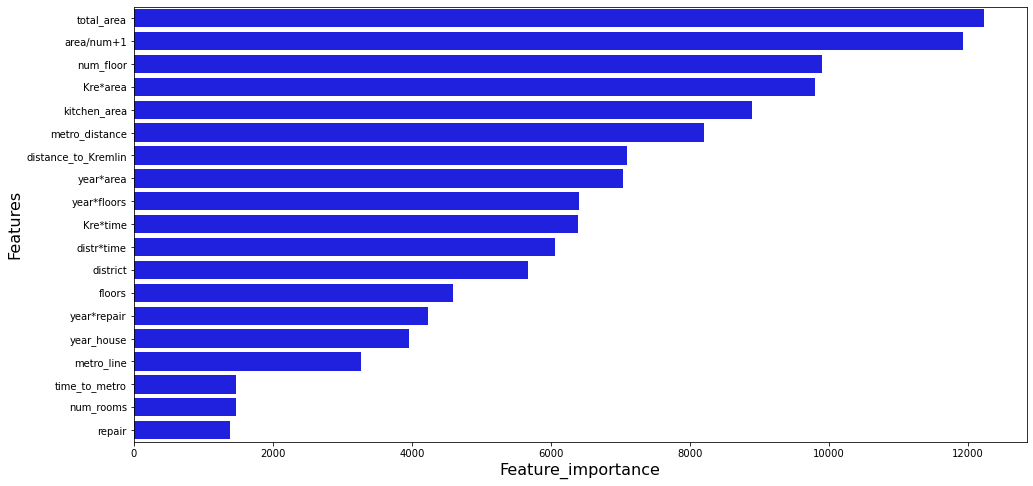

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(16, 8))
    plt.xlabel('Feature_importance', fontsize=16)
    plt.ylabel('Features', fontsize=16)
    sns.barplot(list(f_dict.values()), list(f_dict.keys()), color='blue')

## Permutation importance

Метод основан на перестановке. Модель обучается на части данных, предсказывает результат на валидационной части данных с каким то качеством. Потом признак перемешивается на валидации, и модель делает предсказание еще раз. Разностью в качестве до перемешивания и после оценивается важность признака.

Смотрим важность на кроссвалидации.

In [10]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
perm_imp=[]
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for tr_ind, val_ind in tqdm(skf.split(X, y)):
            
            lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42, **gd.best_params_)
            lgbm.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
            
            perm_imp.append(permutation_importance(lgbm, X.iloc[val_ind], y.iloc[val_ind], random_state=42, scoring='neg_mean_absolute_percentage_error', n_repeats=30))
            


5it [19:59, 239.90s/it]


Создаем табличку

In [11]:
perm_df=pd.DataFrame(columns=['fold №1', 'fold №2', 'fold №3', 'fold №4', 'fold №5', 'mean'], index=X.columns)
for i in range(1,6):
    perm_df[f'fold №{i}']=perm_imp[i-1]['importances_mean']
perm_df['mean']=perm_df.mean(axis=1)

In [12]:
perm_df

,fold №1,fold №2,fold №3,fold №4,fold №5,mean
time_to_metro,0.046296,0.046155,0.058021,0.042620,0.041881,0.046995
num_rooms,0.060330,0.056884,0.054096,0.042224,0.049655,0.052638
total_area,0.738339,0.736152,0.704546,0.745267,0.728895,0.730640
year_house,0.019169,0.019539,0.022069,0.020715,0.020545,0.020408
kitchen_area,0.020014,0.019431,0.022529,0.020647,0.020168,0.020558
repair,0.023160,0.018308,0.019631,0.020662,0.020655,0.020483
floors,0.055320,0.033142,0.044842,0.038445,0.036081,0.041566
num_floor,0.010600,0.011616,0.010372,0.009814,0.010727,0.010626
distance_to_Kremlin,0.098951,0.113557,0.117757,0.158659,0.129065,0.123598
district,0.092931,0.083063,0.096572,0.086403,0.084569,0.088708


Визуализация

<AxesSubplot:xlabel='Feature importance', ylabel='Features'>

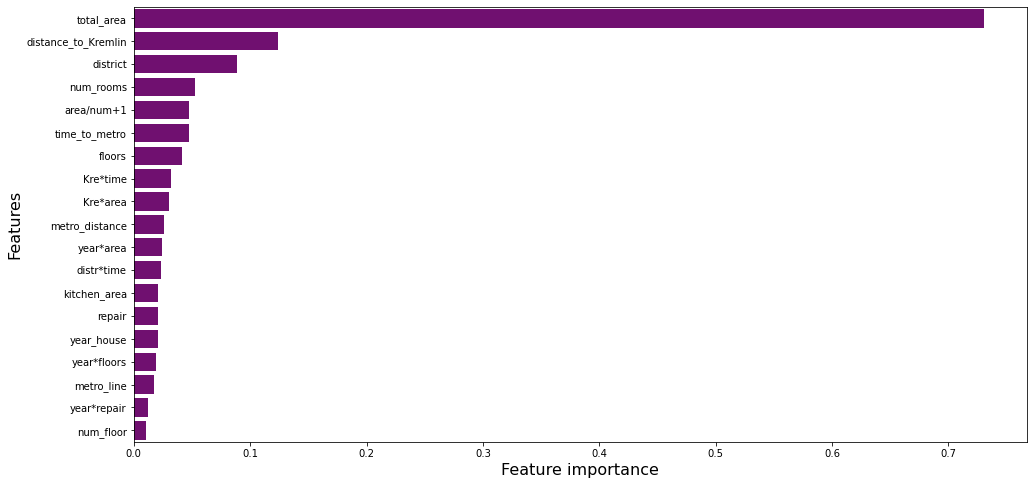

In [13]:
plt.figure(figsize=(16,8))
a=perm_df['mean'].sort_values()[::-1]
plt.xlabel('Feature importance', fontsize=16)
plt.ylabel('Features', fontsize=16)
sns.barplot(x=a.values, y=a.index, color='purple')

Результаты получились слегка отличающиеся от метода split.

## Жадное удалерие признаков

Метод заключается в том, чтобы поочередно удалять признаки, обучать модель на новом датасете и сранивать качество с базом датасетом. Чем больше падение качества- тем выше значимость признака

Каждый раз будем смотреть качество на кросс валидации. Для каждого нового датасета надо будет "тюнить" модель

Качество базового датасета.

In [14]:
lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42)
param_grid={'learning_rate':[0.01,0.05,0.1,0.2], 'n_estimators':[1000,2000, 4000], 'lambda_l1':[5,15,30]}
gd=GridSearchCV(lgbm, param_grid, cv=5)
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    gd.fit(X,y)
print(f'best params: {gd.best_params_}')

best params: {'lambda_l1': 5, 'learning_rate': 0.05, 'n_estimators': 4000}


In [15]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
errors=[]

with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        for tr_ind, val_ind in skf.split(X, y):
            lgbm=LGBMRegressor(bagging_fraction=0.5, **gd.best_params_, random_state=42)
            lgbm.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
            errors.append(mape(y.iloc[val_ind],lgbm.predict(X.iloc[val_ind,:])))
            
print(f'MAPE for f dataset: {np.mean(errors)}')

all_feat_error=np.mean(errors)

MAPE for f dataset: 0.1498223225813041


Поочередно удаляем признаки, тюним модель, получаем качество на кросс-валидации. Сохраняем в словарь.

In [16]:
errors_dict={}

feat_to_drop=[]
col_rfe=perm_df['mean'].sort_values().index
t=0.00001
c=list(f_dict.keys())[::-1]

for i in c:
    
    X_time=X.drop(feat_to_drop+[i], axis=1)

        
        
    errors_t=[]
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            for tr_ind, val_ind in skf.split(X_time, y):
                lgbm=LGBMRegressor(bagging_fraction=0.5, **gd.best_params_, random_state=42)
                lgbm.fit(X_time.iloc[tr_ind,:], y.iloc[tr_ind])
                errors_t.append(mape(y.iloc[val_ind],lgbm.predict(X_time.iloc[val_ind,:])))
                
    errors_dict[i]=np.mean(errors_t)
    
    print(f'Error with drop {i}: {errors_dict[i]}')
    print(f'Error with all features: {all_feat_error}')
    diff_err=errors_dict[i]-all_feat_error
    
    print(f'Difference between errors for {i}: {diff_err}')
    
    if diff_err< t:
        feat_to_drop.append(i)
        print(f'Delete {i}')
    else:
        print(f'Remain {i}')
    print()

Error with drop repair: 0.1501762960971061
Error with all features: 0.1498223225813041
Difference between errors for repair: 0.0003539735158019919
Remain repair

Error with drop num_rooms: 0.15040710490624276
Error with all features: 0.1498223225813041
Difference between errors for num_rooms: 0.0005847823249386652
Remain num_rooms

Error with drop time_to_metro: 0.15119539339236632
Error with all features: 0.1498223225813041
Difference between errors for time_to_metro: 0.0013730708110622214
Remain time_to_metro

Error with drop metro_line: 0.150310071769653
Error with all features: 0.1498223225813041
Difference between errors for metro_line: 0.0004877491883489016
Remain metro_line

Error with drop year_house: 0.15094710998495114
Error with all features: 0.1498223225813041
Difference between errors for year_house: 0.0011247874036470484
Remain year_house

Error with drop year*repair: 0.14907498545408188
Error with all features: 0.1498223225813041
Difference between errors for year*repair

Признаки для удаления

In [17]:
print(feat_to_drop)

['year*repair', 'Kre*time']


## Split в динамике

Здесь мы посмотрим важность split в зависимости от максимальной глубины дерева

In [18]:
max_depth=[1,2,3,4,5]
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
dm_imp=[]
for num in max_depth:
    
    importance=[]
    
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            for tr_ind, val_ind in skf.split(X, y):
                lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42, 
                                   **gd.best_params_, max_depth=num)
                
                lgbm.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
                
                importance.append(lgbm.booster_.feature_importance())


    feat_imp=np.mean(np.array(importance), axis=0)
    
    dm_imp.append(feat_imp)


Создадим таблицу

In [19]:
dm_imp_df=pd.DataFrame(columns=[f'depth {i}' for i in range(1, 6)], index=X.columns)

for i in range(1,6):
    dm_imp_df[f'depth {i}']= dm_imp[i-1]
dm_imp_df['mean']=dm_imp_df.mean(axis=1)


In [20]:
dm_imp_df

,depth 1,depth 2,depth 3,depth 4,depth 5,mean
time_to_metro,416.4,341.0,541.0,680.0,1021.8,600.04
num_rooms,95.2,220.6,446.6,703.8,1109.0,515.04
total_area,668.8,1989.0,3750.8,5728.8,8364.0,4100.28
year_house,371.2,405.6,734.4,1312.0,2142.6,993.16
kitchen_area,207.0,738.2,1672.6,3288.6,5403.8,2262.04
repair,30.4,135.4,284.8,475.8,754.0,336.08
floors,126.4,577.6,1140.6,2009.4,3102.0,1391.20
num_floor,43.6,275.6,1149.6,2826.0,5377.8,1934.52
distance_to_Kremlin,211.2,852.2,1891.0,3333.6,5293.8,2316.36
district,193.4,670.0,1385.0,2453.2,3890.6,1718.44


Визуализация

<AxesSubplot:xlabel='Feature importance', ylabel='Features'>

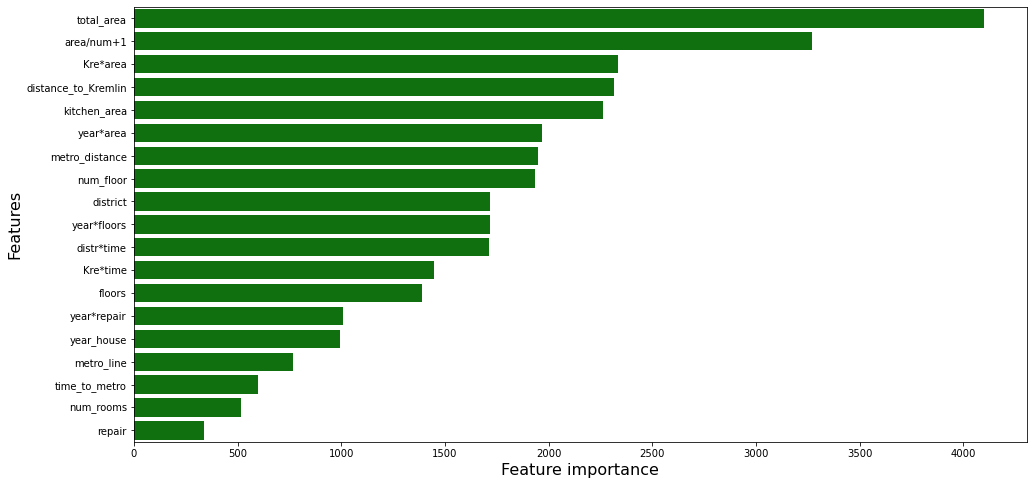

In [21]:
plt.figure(figsize=(16,8))
b=dm_imp_df['mean'].sort_values()[::-1]
plt.xlabel('Feature importance', fontsize=16)
plt.ylabel('Features', fontsize=16)
sns.barplot(x=b.values, y=b.index, color='green')

Разницы особо нет

## Модифицированный backward elimination features

Этот метод заключается в том, чтобы наоборот, находить самые наилучшие признаки и их удалять. Удалять до тех пор, пока значимость самого лучшего признака не будет ниже какого-то порога. Тогда оставшиеся признаки- кандидаты на удаление после отбора, а удаленные-хорошие признаки, которые мы оставляем.

In [22]:
fl=True
k=0
col_drop=[]


while fl or k<X.shape[1]:
    col_errors=[]
    for col in set(X.columns.to_list())-set(col_drop):
        
        X_time=X.drop([col]+col_drop, axis=1)
        
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                errors=[]

                for tr_ind, val_ind in skf.split(X_time, y):
                    lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42, 
                                       **gd.best_params_)

                    lgbm.fit(X_time.iloc[tr_ind,:], y.iloc[tr_ind])

                    errors.append(mape(y.iloc[val_ind],lgbm.predict(X_time.iloc[val_ind,:])))
    
        
        col_errors.append([col,np.mean(errors)])

    max_col=max(col_errors, key=lambda x: x[1])
    min_col=min(col_errors, key=lambda x: x[1])
    if min_col[1]> 1:
        fl=False
        print(f'Feature "{min_col[0]}" mape more then 1')
        break
    else:
        k+=1
        col_drop.append(max_col[0])
        print(f'Feature "{max_col[0]}" remain with mape {max_col[1]}')
    
    print()
    

Feature "district" remain with mape 0.15378063256341554

Feature "distr*time" remain with mape 0.1589818538001554

Feature "metro_line" remain with mape 0.16461517319900473

Feature "metro_distance" remain with mape 0.17155933328485254

Feature "distance_to_Kremlin" remain with mape 0.17862183149366626

Feature "Kre*time" remain with mape 0.18823729610448056

Feature "Kre*area" remain with mape 0.23042099163164717

Feature "time_to_metro" remain with mape 0.263978929666844

Feature "kitchen_area" remain with mape 0.27306101201166405

Feature "year_house" remain with mape 0.2762700662257798

Feature "year*floors" remain with mape 0.2786928389337551

Feature "floors" remain with mape 0.3196410743015804

Feature "num_floor" remain with mape 0.32830105586392816

Feature "year*repair" remain with mape 0.3366162100064506

Feature "repair" remain with mape 0.3501039068981444

Feature "year*area" remain with mape 0.3596113747371742

Feature "total_area" remain with mape 0.360837237266033

Feat

In [23]:
col_errors

[['area/num+1', 1.3602795432000674]]

In [24]:
set(X.columns.to_list())-set(col_drop)

{'area/num+1'}

Список признаков для удаления

In [25]:
set(X.columns.to_list())-set(col_drop)

{'area/num+1'}

# Удаляем признаки

Самые частые кандидаты на удаление

In [26]:
bad_feats=['time_to_metro', 'year*repair']

Попробуем разные комбинации для удаления.

In [27]:
            
for i in [[],['time_to_metro','year*repair'],['time_to_metro'], ['year*repair']]:
    
    errors=[]
    
    X_t=X.drop(i, axis=1)

    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
    
            for tr_ind, val_ind in skf.split(X_t, y):

                    lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42, 
                                           **gd.best_params_)

                    lgbm.fit(X_t.iloc[tr_ind,:], y.iloc[tr_ind])

                    errors.append(mape(y.iloc[val_ind],lgbm.predict(X_t.iloc[val_ind])))
                          
    print(f'Mape with delete this features: {i} equals {np.mean(errors)}')
    

Mape with delete this features: [] equals 0.1498223225813041
Mape with delete this features: ['time_to_metro', 'year*repair'] equals 0.1515852021567931
Mape with delete this features: ['time_to_metro'] equals 0.15119539339236632
Mape with delete this features: ['year*repair'] equals 0.14907498545408188


Удалим только $year*repair$

In [28]:
df_le=df_le.drop('year*repair', axis=1)
df_mte=df_mte.drop('year*repair', axis=1)

# Сохраняем данные

In [29]:
df_le.to_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_delete_le.csv")
df_mte.to_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_delete_mte.csv")